In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn

import torch.optim as optim
import torch.utils.data as data

## Data Preprocessing

In [2]:
### Read in the data and filter for Massachusetts Data
covid_hospitalization_data = pd.read_csv("/Users/alex/Documents/Covid_Data/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW_.csv")
covid_hospitalization_data["date"] = pd.to_datetime(covid_hospitalization_data["date"])
MA_data = covid_hospitalization_data[covid_hospitalization_data['state']=='MA'].sort_values('date')
MA_data.head()

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,previous_day_admission_pediatric_covid_confirmed_5_11_coverage,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_unknown_coverage,staffed_icu_pediatric_patients_confirmed_covid,staffed_icu_pediatric_patients_confirmed_covid_coverage,staffed_pediatric_icu_bed_occupancy,staffed_pediatric_icu_bed_occupancy_coverage,total_staffed_pediatric_icu_beds,total_staffed_pediatric_icu_beds_coverage,Demo | State Geographic Boundaries
15475,MA,2020-03-27,0,0,1,0,0,1,0.0,1,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
17144,MA,2020-03-28,0,0,1,0,0,1,0.0,1,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
15869,MA,2020-03-29,0,0,2,0,0,2,0.0,2,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
20763,MA,2020-03-30,0,0,6,0,0,6,0.0,5,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
16094,MA,2020-03-31,0,0,11,0,0,11,0.0,9,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN


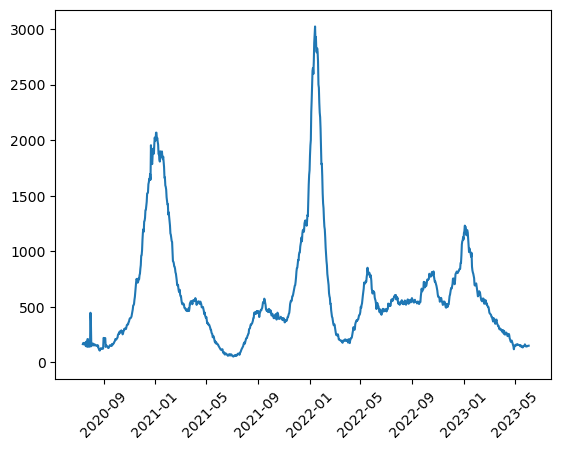

In [3]:
### Define the target variable and plot the trend of data
target_variable = 'total_adult_patients_hospitalized_confirmed_covid'

plt.plot(MA_data['date'],MA_data[target_variable])
plt.xticks(rotation=45)
plt.show()

In [4]:
target_serial_data = MA_data[["date",target_variable]]
target_serial_data.set_index('date',inplace=True)

### Check the first available data date for Massachusetts 
print(np.where(target_serial_data.isna() | (target_serial_data == 0))[0].max())

### Log transform the data
target_serial_data = target_serial_data[109:]
target_serial_data['log_'+target_variable] = np.log(target_serial_data[target_variable])

target_serial_data

108


,total_adult_patients_hospitalized_confirmed_covid,log_total_adult_patients_hospitalized_confirmed_covid
date,,
2020-07-14,165.0,5.105945
2020-07-15,175.0,5.164786
2020-07-16,176.0,5.170484
2020-07-17,164.0,5.099866
2020-07-18,173.0,5.153292
...,...,...
2023-05-30,149.0,5.003946
2023-05-31,146.0,4.983607
2023-06-01,149.0,5.003946


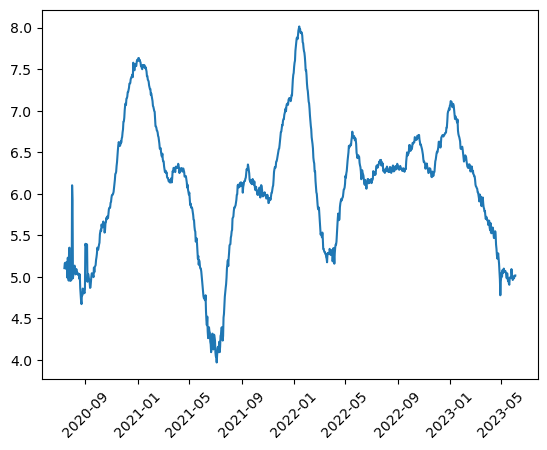

In [5]:
### Visualize the data after log transformation
plt.plot(target_serial_data['log_'+target_variable])
plt.xticks(rotation=45)
plt.show()

## One Day Ahead Prediction LSTM

In [7]:
def create_dataset(dataset, lookback, skip = 0, same_dim_target = True):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    
    if same_dim_target == True:
        for i in range(len(dataset)-lookback-skip):
            feature = dataset[i:i+lookback]
            target = dataset[i+skip+1:i+lookback+skip+1]
            X.append(feature)
            y.append(target)
    else:
        for i in range(len(dataset)-lookback-skip):
            feature = dataset[i:i+lookback]
            target = dataset[i+lookback+skip]
            X.append(feature)
            y.append([target])
    
    return torch.tensor(X), torch.tensor(y)

In [6]:
log_target_serial_data = target_serial_data[['log_'+target_variable]].values.astype('float32')

train_size = int(len(log_target_serial_data) * 0.67)
test_size = len(log_target_serial_data) - train_size
train, test = log_target_serial_data[:train_size], log_target_serial_data[train_size:]


In [8]:
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([699, 7, 1]) torch.Size([699, 7, 1])
torch.Size([342, 7, 1]) torch.Size([342, 7, 1])


/var/folders/4x/v484jjj95cn1j9m1kqx7srth0000gn/T/ipykernel_72400/814061727.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343680142/work/torch/csrc/utils/tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


In [94]:
import torch.nn as nn
 
class Hosp_Model(nn.Module):
    def __init__(self, dropout_p = 0):
        super().__init__()
        
        self.dropout_p = dropout_p
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
        self.dropout = nn.Dropout(p = self.dropout_p)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        
        if self.dropout_p != 0:
            x = self.dropout(x)
            
        x = self.linear(x)
        return x

In [10]:
class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()

    def forward(self, y, y_hat):
        mape = torch.abs(y - y_hat) / torch.abs(y)
        mape = torch.mean(mape)
        return mape

In [11]:
model = Hosp_Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = loss_fn(y_pred, y_train)
        y_pred = model(X_test)
        test_rmse = loss_fn(y_pred, y_test)
    print("Epoch %d: train MSE %.4f, test MSE %.4f" % (epoch, train_rmse, test_rmse))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch 0: train MSE 4.2194, test MSE 3.9678
Epoch 100: train MSE 0.0070, test MSE 0.0019
Epoch 200: train MSE 0.0073, test MSE 0.0028
Epoch 300: train MSE 0.0070, test MSE 0.0025
Epoch 400: train MSE 0.0068, test MSE 0.0025
Epoch 500: train MSE 0.0061, test MSE 0.0018
Epoch 600: train MSE 0.0064, test MSE 0.0023
Epoch 700: train MSE 0.0063, test MSE 0.0021
Epoch 800: train MSE 0.0068, test MSE 0.0029
Epoch 900: train MSE 0.0062, test MSE 0.0027
Epoch 1000: train MSE 0.0054, test MSE 0.0017
Epoch 1100: train MSE 0.0054, test MSE 0.0019
Epoch 1200: train MSE 0.0053, test MSE 0.0019
Epoch 1300: train MSE 0.0054, test MSE 0.0023
Epoch 1400: train MSE 0.0054, test MSE 0.0021
Epoch 1500: train MSE 0.0052, test MSE 0.0020
Epoch 1600: train MSE 0.00

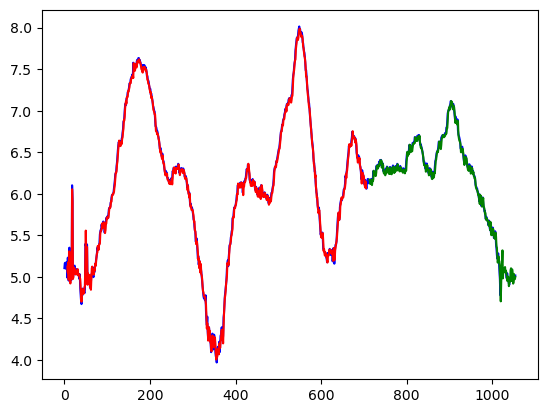

In [12]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(log_target_serial_data) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(log_target_serial_data) * np.nan
    test_plot[train_size+lookback:len(log_target_serial_data)] = model(X_test)[:, -1, :]
# plot
plt.plot(log_target_serial_data, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

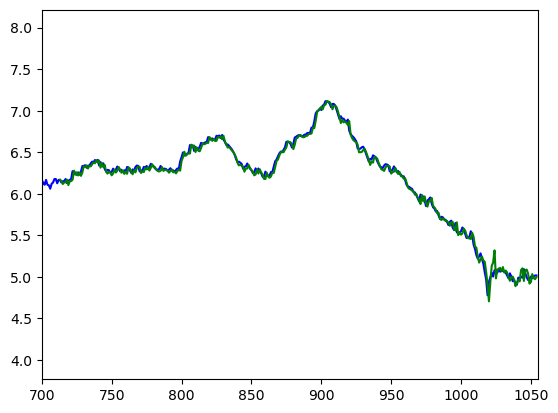

In [13]:
plt.plot(log_target_serial_data, c='b')
plt.plot(test_plot, c='g')
plt.xlim([700,len(log_target_serial_data)])
plt.show()

## Four Weeks Ahead LSTM Prediction

In [89]:
lookback = 7
skip = 7

four_weeks_X_train, four_weeks_y_train = create_dataset(train, 
                                                        lookback = lookback,
                                                        skip = skip,
                                                        same_dim_target = True)

four_weeks_X_test, four_weeks_y_test = create_dataset(test, 
                                                      lookback = lookback,
                                                      skip = skip,
                                                      same_dim_target = True)

print(four_weeks_X_train.shape, four_weeks_y_train.shape)
print(four_weeks_X_test.shape, four_weeks_y_test.shape)

torch.Size([692, 7, 1]) torch.Size([692, 7, 1])
torch.Size([335, 7, 1]) torch.Size([335, 7, 1])


In [95]:
model = Hosp_Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(four_weeks_X_train, four_weeks_y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000

train_loss_history = []
test_loss_history = []

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        
        y_pred = model(four_weeks_X_train)
        train_loss = loss_fn(y_pred, four_weeks_y_train)
        train_loss_history.append(train_loss)
        
        y_pred = model(four_weeks_X_test)
        test_loss = loss_fn(y_pred, four_weeks_y_test)
        test_loss_history.append(test_loss)
        
    print("Epoch %d: train MSE %.4f, test MSE %.4f" % (epoch, train_loss, test_loss))

Epoch 0: train MSE 5.8107, test MSE 5.6585
Epoch 100: train MSE 0.0595, test MSE 0.0232
Epoch 200: train MSE 0.0547, test MSE 0.0216
Epoch 300: train MSE 0.0525, test MSE 0.0197
Epoch 400: train MSE 0.0517, test MSE 0.0203
Epoch 500: train MSE 0.0464, test MSE 0.0189
Epoch 600: train MSE 0.0465, test MSE 0.0200
Epoch 700: train MSE 0.0444, test MSE 0.0198
Epoch 800: train MSE 0.0434, test MSE 0.0178
Epoch 900: train MSE 0.0425, test MSE 0.0185
Epoch 1000: train MSE 0.0435, test MSE 0.0210
Epoch 1100: train MSE 0.0405, test MSE 0.0191
Epoch 1200: train MSE 0.0424, test MSE 0.0247
Epoch 1300: train MSE 0.0396, test MSE 0.0190
Epoch 1400: train MSE 0.0383, test MSE 0.0221
Epoch 1500: train MSE 0.0387, test MSE 0.0206
Epoch 1600: train MSE 0.0366, test MSE 0.0196
Epoch 1700: train MSE 0.0371, test MSE 0.0212
Epoch 1800: train MSE 0.0379, test MSE 0.0201
Epoch 1900: train MSE 0.0344, test MSE 0.0215


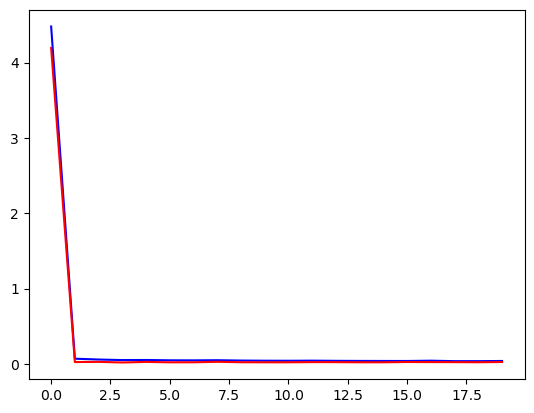

In [80]:
### Plot the train and test loss
plt.plot(train_loss_history, c = 'b')
plt.plot(test_loss_history, c = 'r')

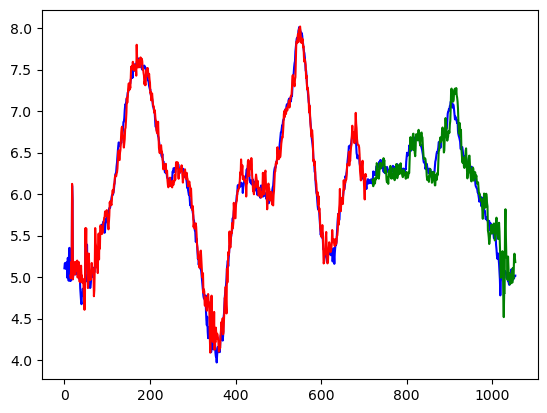

In [81]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(log_target_serial_data) * np.nan
    train_plot[lookback + skip : train_size] = model(four_weeks_X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(log_target_serial_data) * np.nan
    test_plot[train_size + lookback + skip : len(log_target_serial_data)] = model(four_weeks_X_test)[:, -1, :]
# plot
plt.plot(log_target_serial_data, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

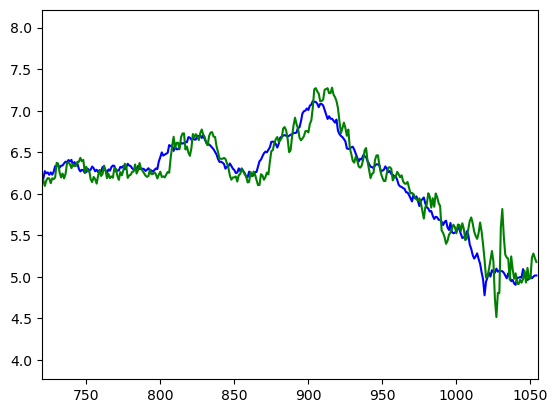

In [82]:
plt.plot(log_target_serial_data, c='b')
plt.plot(test_plot, c='g')
plt.xlim([train_size + lookback + skip,len(log_target_serial_data)])
plt.show()

## LSTM with Dropout Regularization

In [110]:
lookback = 14
skip = 28

four_weeks_X_train, four_weeks_y_train = create_dataset(train, 
                                                        lookback = lookback,
                                                        skip = skip,
                                                        same_dim_target = True)

four_weeks_X_test, four_weeks_y_test = create_dataset(test, 
                                                      lookback = lookback,
                                                      skip = skip,
                                                      same_dim_target = True)

print(four_weeks_X_train.shape, four_weeks_y_train.shape)
print(four_weeks_X_test.shape, four_weeks_y_test.shape)

torch.Size([664, 14, 1]) torch.Size([664, 14, 1])
torch.Size([307, 14, 1]) torch.Size([307, 14, 1])


In [111]:
model = Hosp_Model(dropout_p=0.5)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(four_weeks_X_train, four_weeks_y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000

train_loss_history = []
test_loss_history = []

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        
        y_pred = model(four_weeks_X_train)
        train_loss = loss_fn(y_pred, four_weeks_y_train)
        train_loss_history.append(train_loss)
        
        y_pred = model(four_weeks_X_test)
        test_loss = loss_fn(y_pred, four_weeks_y_test)
        test_loss_history.append(test_loss)
        
    print("Epoch %d: train MSE %.4f, test MSE %.4f" % (epoch, train_loss, test_loss))

Epoch 0: train MSE 3.5216, test MSE 3.1787
Epoch 100: train MSE 0.5047, test MSE 0.1783
Epoch 200: train MSE 0.3555, test MSE 0.2614
Epoch 300: train MSE 0.2626, test MSE 0.2047
Epoch 400: train MSE 0.2417, test MSE 0.2810
Epoch 500: train MSE 0.2170, test MSE 0.2986
Epoch 600: train MSE 0.2058, test MSE 0.3374
Epoch 700: train MSE 0.1994, test MSE 0.3533
Epoch 800: train MSE 0.1683, test MSE 0.3282
Epoch 900: train MSE 0.1619, test MSE 0.3900
Epoch 1000: train MSE 0.1574, test MSE 0.3894
Epoch 1100: train MSE 0.1716, test MSE 0.2948
Epoch 1200: train MSE 0.1538, test MSE 0.3382
Epoch 1300: train MSE 0.1577, test MSE 0.3353
Epoch 1400: train MSE 0.1481, test MSE 0.4241
Epoch 1500: train MSE 0.1398, test MSE 0.3428
Epoch 1600: train MSE 0.1349, test MSE 0.4210
Epoch 1700: train MSE 0.1407, test MSE 0.3724
Epoch 1800: train MSE 0.1332, test MSE 0.3590
Epoch 1900: train MSE 0.1244, test MSE 0.4019


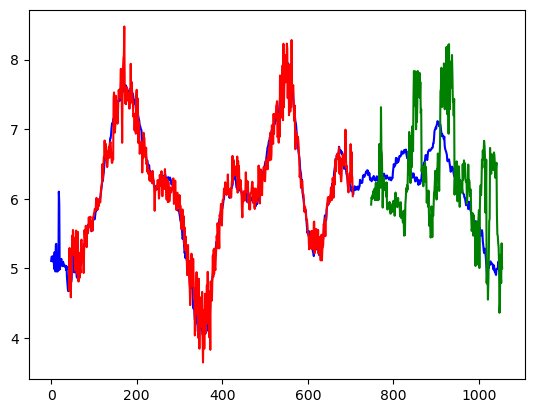

In [112]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(log_target_serial_data) * np.nan
    train_plot[lookback + skip : train_size] = model(four_weeks_X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(log_target_serial_data) * np.nan
    test_plot[train_size + lookback + skip : len(log_target_serial_data)] = model(four_weeks_X_test)[:, -1, :]
# plot
plt.plot(log_target_serial_data, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

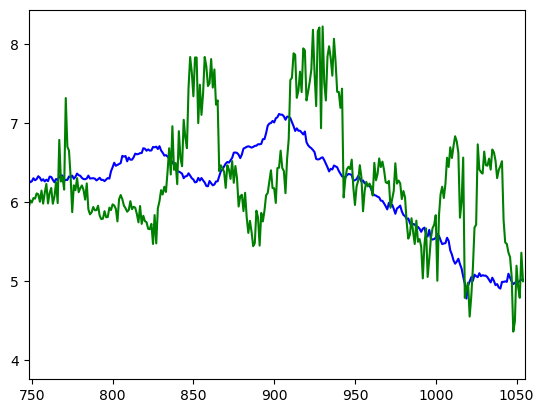

In [113]:
plt.plot(log_target_serial_data, c='b')
plt.plot(test_plot, c='g')
plt.xlim([train_size + lookback + skip,len(log_target_serial_data)])
plt.show()